In [1]:
# This notebook looks into how existing vanilla transformers do math

In [1]:
# ----- dependencies
!pip install transformers 
#!pip install git+https://github.com/huggingface/transformers #accelerate deepspeed
!pip install -U huggingface_hub
!pip install -U accelerate
!pip install --upgrade pip
!pip install torch

You should consider upgrading via the 'c:\users\idmi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.15.1
    Uninstalling huggingface-hub-0.15.1:
      Successfully uninstalled huggingface-hub-0.15.1


You should consider upgrading via the 'c:\users\idmi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\idmi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: pip
    Found existing installation: pip 21.1.1
    Uninstalling pip-21.1.1:
      Successfully uninstalled pip-21.1.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\idmi\\AppData\\Local\\Temp\\pip-uninstall-02kkeemc\\pip.exe'
Consider using the `--user` option or check the permissions.



   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -- ------------------------------------- 0.1/2.2 MB 2.7 MB/s eta 0:00:01
   ---- ----------------------------------- 0.2/2.2 MB 3.0 MB/s eta 0:00:01
   ------ --------------------------------- 0.4/2.2 MB 2.6 MB/s eta 0:00:01
   ---------- ----------------------------- 0.6/2.2 MB 2.9 MB/s eta 0:00:01
   ------------- -------------------------- 0.7/2.2 MB 3.0 MB/s eta 0:00:01
   ---------------- ----------------------- 0.9/2.2 MB 3.1 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.2 MB 3.2 MB/s eta 0:00:01
   ---------------------- ----------------- 1.2/2.2 MB 3.2 MB/s eta 0:00:01
   ------------------------ --------------- 1.3/2.2 MB 3.1 MB/s eta 0:00:01
   --------------------------- ------------ 1.5/2.2 MB 3.2 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.2 MB 3.2 MB/s eta 0:00:01
   --------------------------------- ------ 1.8/2.2 MB 3.2 MB/s eta 0:00:01
   ----------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.30.0 requires tokenizers!=0.11.3,<0.14,>=0.11.1, but you have tokenizers 0.14.0 which is incompatible.


In [4]:
!pip install tokenizers==0.13.0 # may need 14 or 13 depending on python version


     ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
     - -------------------------------------- 0.1/3.3 MB 2.2 MB/s eta 0:00:02
     --- ------------------------------------ 0.3/3.3 MB 2.9 MB/s eta 0:00:02
     ---- ----------------------------------- 0.4/3.3 MB 2.7 MB/s eta 0:00:02
     ------ --------------------------------- 0.5/3.3 MB 2.7 MB/s eta 0:00:02
     ------- -------------------------------- 0.6/3.3 MB 2.7 MB/s eta 0:00:02
     -------- ------------------------------- 0.7/3.3 MB 2.6 MB/s eta 0:00:02
     ---------- ----------------------------- 0.9/3.3 MB 2.7 MB/s eta 0:00:01
     ------------ --------------------------- 1.0/3.3 MB 2.6 MB/s eta 0:00:01
     ------------- -------------------------- 1.1/3.3 MB 2.5 MB/s eta 0:00:01
     ------------- -------------------------- 1.1/3.3 MB 2.4 MB/s eta 0:00:01
     -------------- ------------------------- 1.2/3.3 MB 2.3 MB/s eta 0:00:01
     --------------- ------------------------ 1.3/3.3 MB 2.3 MB/s eta 0

In [5]:
# ----- dependencies
import os
import torch
from transformers import LlamaModel, LlamaConfig, LlamaForCausalLM
from huggingface_hub import login
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# --- character-level tokenizer
class Char_Tokenizer():

    def __init__(self):
        self.chars = ['<pad>','<s>','</s>','0','1','2','3','4','5','6','7','8','9','+','=',' ']
        self.bos_token=1
        self.eos_token=2
        self.pad_token=0
        self.vocab_size = len(self.chars)
        self.char2idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx2char = {i: ch for i, ch in enumerate(self.chars)}

    def tokenize(self, text, max_length=None):
        list = [self.char2idx[ch] for ch in text]
        list.insert(0,self.bos_token) # prefix <s>
        list.append(self.eos_token) # suffix </s>
        if max_length is None:
            return list
        else: # padding/cropping if max length is specified
            list += [self.pad_token for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
            return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])
    
tokenizer = Char_Tokenizer()
vocab_size = tokenizer.vocab_size


In [7]:

# ----- HYPERPARAMETERS
LLM_context_length = 20 
LLM_hid =      384 # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to smalltansformers
LLM_layers =   6
LLM_n_heads =  6

# --- training
batch_size = 256
iterations = 5000
epochs = 1


In [63]:
# ------- Initialize model


# --- Create non-causal concept encoder (C) (tokens to concepts)
# the final autorecressive decoder-only model will use itself as the encoder - note that for char-level or removing tokenizer dependency we will need a separate encoder so that decoder take in only high level concepts
half_config = LlamaConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=LLM_hid,
    intermediate_size=LLM_hid*4,
    num_hidden_layers=LLM_layers,
    num_attention_heads=LLM_n_heads,
    num_key_value_heads=None,
    hidden_act='silu',
    max_position_embeddings=LLM_context_length,
    initializer_range=0.02,
    rms_norm_eps=1e-06,
    use_cache=True,
    pad_token_id=None,
    bos_token_id=tokenizer.bos_token,
    eos_token_id=tokenizer.eos_token,
    pretraining_tp=1,
    tie_word_embeddings=False,
    rope_theta=10000.0,
    rope_scaling=None)

# --- Create causal concept decoder (D) (concepts to concepts)
LLM_decoder = LlamaForCausalLM(half_config).to(device)#.to(torch.bfloat16)
LLM_decoder.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(16, 384)
    (layers): ModuleList(
      (0-5): 6 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=384, out_features=384, bias=False)
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=384, bias=False)
          (o_proj): Linear(in_features=384, out_features=384, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=384, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=384, bias=False)
          (up_proj): Linear(in_features=384, out_features=1536, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_fea

In [64]:
import random

eval_pairs = []

for i in range((2000//batch_size)*batch_size):
    eval_pairs.append((random.randint(0, 999), random.randint(0, 999)))

len(eval_pairs)

1792

In [65]:

# ------- TRAINING RUN
from transformers import top_k_top_p_filtering
import random


# --- Define the optimizer and loss function
optimizer = optim.AdamW(LLM_decoder.parameters(), lr=1e-4, betas=(0.9,0.99), weight_decay=0.1) # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to small transformers
warmup_iters = 100 # pre-ln transformers dont need warmup # # learning rate decay scheduler (cosine with warmup) from karpathy's nano-gpt
lr_decay_iters = iterations
learning_rate = 0.001
min_lr = 1e-5
import math
def get_lr(it):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)



losses = []
accs = []
eval_losses = []
eval_accs = []
generations = []

LLM_decoder.train()
it = 0
for _ in range(epochs):
    for b in range(iterations):

        # get batch x, y
        batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
        for b_idx in range(batch_size):
            num1,num2=eval_pairs[0]
            while ((num1,num2) in eval_pairs) or ((num2,num1) in eval_pairs):            
                num1 = random.randint(0, 999)
                num2 = random.randint(0, 999)
            result = str(num1 + num2)
            problem = f"{num1}+{num2}={result}"
            tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
            batch_input_ids[b_idx][:] = torch.tensor(tokenized)
        labels = batch_input_ids.clone()
        labels[labels==tokenizer.pad_token] = -100

        # update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = get_lr(it)

        # forward pass
        output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
        loss = output.loss
    

        # Iterate through each sample in the batch
        b_accs=[]
        for s in range(batch_size):
            # Find the index of the token with value 14 in the 'labels' tensor for the current sample
            index_14 = (labels[s] == 14).nonzero(as_tuple=True)
            index_14 = index_14[0][0]
            # Calculate accuracy only for tokens after index_14 for the current sample
            predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
            correct_predictions = (predicted_labels[index_14+1:] == labels[s, index_14+1:].roll(-1, dims=0)).float()
            # Calculate the accuracy for tokens after index_14 for the current sample
            b_accs.append(correct_predictions.mean().item())
        accs.append(torch.tensor(b_accs).mean().item())

        # Step 5: Train D on the modified inputs and token labels
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        losses.append(loss.item())

        it += 1

        # GET GENERATION SAMPLES (not optimized w/ cache):
        if it%100==0:
            with torch.no_grad():
                LLM_decoder.eval()



                # =============== EVAL LOSS
                total_batch_acc = []
                for eval_batch in range(0, len(eval_pairs), batch_size):
                    batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
                    for b_idx in range(batch_size):
                        num1,num2 = eval_pairs[eval_batch + b_idx]
                        result = str(num1 + num2)
                        problem = f"{num1}+{num2}={result}"
                        tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
                        batch_input_ids[b_idx][:] = torch.tensor(tokenized)
                    labels = batch_input_ids.clone()

                    # forward pass
                    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
                    loss = output.loss
                    eval_losses.append(loss.item())

                    # GET ACC
                    b_accs=[]
                    for s in range(batch_size):
                        # Find the index of the token with value 14 in the 'labels' tensor for the current sample
                        index_14 = (labels[s] == 14).nonzero(as_tuple=True)
                        index_14 = index_14[0][0]
                        eos = (labels[s] == tokenizer.eos_token).nonzero(as_tuple=True)
                        eos = eos[0][0]
                        # Calculate accuracy only for tokens after index_14 for the current sample
                        predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
                        predicted_number = predicted_labels[index_14:eos-1]
                        correct_number = labels[s,index_14+1:eos]
                        predicted_number = tokenizer.detokenize(predicted_number.tolist())
                        correct_number = tokenizer.detokenize(correct_number.tolist()) 
                        #print('Y_:'+predicted_number)
                        #print('Y:'+correct_number)
                        #print()
                        
                        # whole number acc
                        if True:
                            try:
                                b_accs.append(float(int(predicted_number)==int(correct_number)))
                            except:
                                b_accs.append(0)
                        # per digit acc
                        else:
                            correct_predictions = (predicted_labels[index_14:eos-1] == labels[s, index_14+1:eos]).float()
                            b_accs.append(correct_predictions.mean().item())
                    total_batch_acc.append(torch.tensor(b_accs).mean().item())
                eval_accs.append(torch.tensor(total_batch_acc).mean().item())


                # ============================================================================ GENERATIVE AUTOREGRESSIVE INFERENCE
                input_ids = torch.tensor([[tokenizer.bos_token]])
                while input_ids.shape[1] < LLM_context_length:
                    output = LLM_decoder(input_ids=input_ids.to(device))
                    logits = output.logits.cpu()
                    next_token_logits = logits[:, -1, :]
                    next_token_id = torch.multinomial(torch.softmax(next_token_logits, dim=-1), 1)
                    input_ids = torch.cat([input_ids, next_token_id], dim=1)
                print(tokenizer.detokenize(input_ids[0].tolist()))
                LLM_decoder.train()

                print(it,':', eval_losses[-1], eval_accs[-1], 'lr',get_lr(it))


<s>651+899=1483</s></s></s></s></s></s></s>
100 : 3.7379648685455322 0.0022321429569274187 lr 0.001
<s>943+847=1773</s></s></s></s>+32
200 : 4.060156345367432 0.010044642724096775 lr 0.0009989829694114164
<s>909+233=1242</s></s></s>6334
300 : 3.9035003185272217 0.5100446343421936 lr 0.0009959360568425068
<s>713+15=745</s></s></s></s></s></s></s></s></s>
400 : 3.8892664909362793 0.8498883843421936 lr 0.0009908717827105773
<s>659+396=1055</s></s></s></s>7</s>0
500 : 4.194406032562256 0.8621651530265808 lr 0.0009838109572043196
<s>157+336=493</s></s></s></s></s></s></s></s>
600 : 4.203091144561768 0.7042410969734192 lr 0.000974782594770281
<s>44+357=401</s></s></s></s></s>0</s></s></s>
700 : 4.5337677001953125 0.8889508843421936 lr 0.0009638237948862808
<s>671+625=1296</s></s></s></s></s>6</s>
800 : 4.612562656402588 0.9040178656578064 lr 0.0009509795896116975
<s>549+103=652</s></s></s></s>54</s></s>
900 : 4.802606105804443 0.9017857313156128 lr 0.0009363027585410778
<s>806+584=1390</s></

5000 350


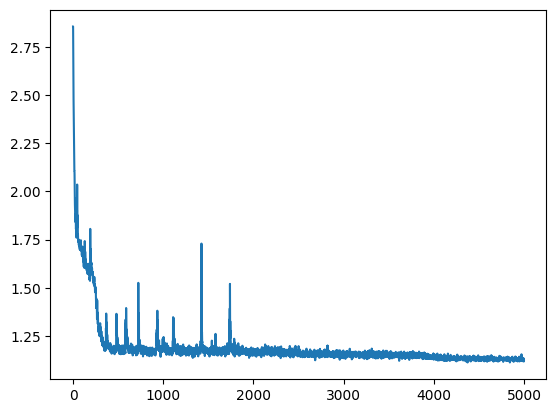

In [71]:
import matplotlib.pyplot as plt
print(len(losses), len(eval_losses))
plt.plot(losses)


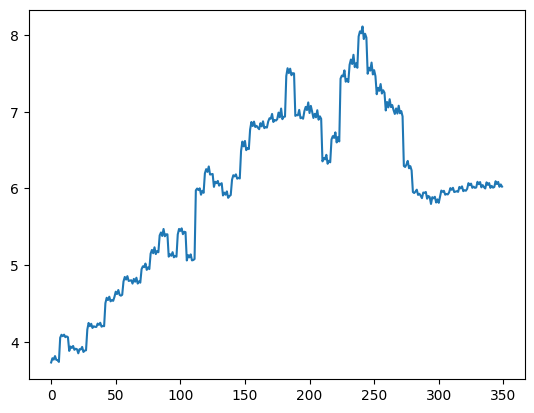

In [72]:
plt.plot(eval_losses)

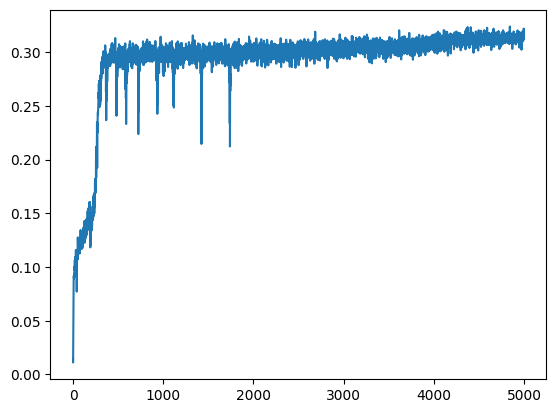

In [73]:
plt.plot(accs)

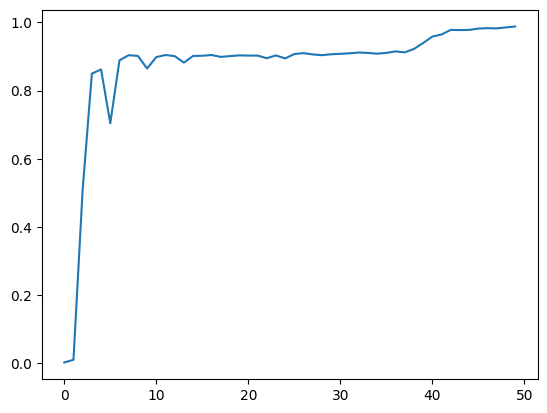

In [74]:
plt.plot(eval_accs)

In [83]:
!pip install bertviz
from bertviz import model_view


In [95]:


# create math input
batch_input_ids = torch.zeros([1,LLM_context_length],dtype=torch.long)
num1 = random.randint(0, 999)
num2 = random.randint(0, 999)
result = str(num1 + num2)
problem = f"{num1}+{num2}={result}"
tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
batch_input_ids[0][:] = torch.tensor(tokenized)

labels = batch_input_ids.clone()
labels[labels==tokenizer.pad_token] = -100

# forward pass
LLM_decoder.eval()
with torch.no_grad():
    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device), output_attentions=True) 
attention = output[-1]

a=tokenizer.detokenize(tokenized)
print(a)
model_view(attention, a.replace('<s>', '_').replace('</s>', '_').replace('<pad>', '_'))


<s>226+316=542</s><pad><pad><pad><pad><pad><pad><pad>


<IPython.core.display.Javascript object>